## DATA LOADING

In [2]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class PaddedSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir

        # Filter and sort valid image filenames
        self.filenames = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.images_dir, fname)
        mask_path = os.path.join(self.masks_dir, os.path.splitext(fname)[0] + ".png")

        # Load image and corresponding mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        target_h, target_w = 640, 1024
        w, h = image.size

        # Pad only height if needed (width assumed fixed)
        if h < target_h:
            pad_h = target_h - h
            pad_top = pad_h // 2
            pad_bottom = pad_h - pad_top
            padding = (0, pad_top, 0, pad_bottom)  # left, top, right, bottom
            image = TF.pad(image, padding, fill=0)
            mask = TF.pad(mask, padding, fill=0)

        # Convert to tensor
        image_tensor = TF.to_tensor(image)

        # Process mask to class labels: 0 (background), 1 (crack), 2 (pothole)
        mask_np = np.array(mask, dtype=np.uint8)
        mask_np = np.where(mask_np == 255, 2, np.where(mask_np == 127, 1, 0))
        mask_tensor = torch.from_numpy(mask_np).long()

        return image_tensor, mask_tensor

In [3]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

# Root directory of your segmentation dataset
root_dir = r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset"

# Create datasets
train_dataset = PaddedSegmentationDataset(
    images_dir=os.path.join(root_dir, "train", "images"),
    masks_dir=os.path.join(root_dir, "train", "masks")
)
val_dataset = PaddedSegmentationDataset(
    images_dir=os.path.join(root_dir, "val", "images"),
    masks_dir=os.path.join(root_dir, "val", "masks")
)
test_dataset = PaddedSegmentationDataset(
    images_dir=os.path.join(root_dir, "test", "images"),
    masks_dir=os.path.join(root_dir, "test", "masks")
)

# Create data loaders (global scope)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# Quick test to verify loading
for imgs, masks in tqdm(train_loader, desc="Loading train batches"):
    print("Image batch:", imgs.shape)  # e.g. [8, 3, 640, 1024]
    print("Mask batch:", masks.shape)  # e.g. [8, 640, 1024]
    break

Loading train batches:   0%|                                                                   | 0/224 [00:00<?, ?it/s]

Image batch: torch.Size([8, 3, 640, 1024])
Mask batch: torch.Size([8, 640, 1024])


## TRAINING

In [4]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

In [5]:
# Define UNet model with resnet34 encoder
model = smp.Unet(
    encoder_name="resnet34",        # resnet34 as backbone
    encoder_weights="imagenet",         # Pretrained on ImageNet
    in_channels=3,                      # RGB images
    classes=3                           # 3 classes: {0, 1, 2}
)

In [6]:
import torch

# Best device practice
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optional but helpful for consistent input sizes (improves cuDNN performance)
torch.backends.cudnn.benchmark = True

# Move model to device
model = model.to(device)

In [7]:
# Block 3 - Modified
import torch.nn as nn
import torch.optim as optim

# Class weights - adjust these based on your dataset statistics
class_weights = torch.tensor([0.1, 2.0, 1.5])  # [background, crack, pothole]
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Optimizer remains the same
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [8]:
import torch
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt
import csv

# Device setup (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(
    model, train_loader, val_loader, criterion, optimizer,
    num_epochs=10,
    save_path="best_model.pth",
    last_model_path="last_model.pth",
    checkpoint_path="checkpoint.pth",
    pause_file="pause.flag"
):
    start_epoch = 0
    best_miou = -1.0

    miou_list = []
    dice_list = []


    # Resume from checkpoint if exists
    if os.path.exists(checkpoint_path):
        print("🔁 Resuming from checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_miou = checkpoint.get('best_miou', -1.0)
        print(f"➡️ Resumed from epoch {start_epoch}, Best mIoU so far: {best_miou:.4f}")

    model.to(device)
    print(f"📟 Using device: {device}")

    for epoch in range(start_epoch, num_epochs):
        while os.path.exists(pause_file):
            print("⏸️ Training paused. Remove 'pause.flag' to resume.")
            time.sleep(5)

        model.train()
        train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)

        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"\n📘 Epoch {epoch+1}: Avg Train Loss = {avg_train_loss:.4f}")

        val_loss, miou, dice, ious, dices = validate(model, val_loader, criterion)

        miou_list.append(miou)
        dice_list.append(dice)
        # Save best model by mIoU
        if miou > best_miou:
            best_miou = miou
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved! mIoU = {best_miou:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_miou': best_miou
        }, checkpoint_path)
        print(f"💾 Checkpoint saved at epoch {epoch+1}")

    # Save last model after training
    torch.save(model.state_dict(), last_model_path)
    print(f"📦 Final model saved to: {last_model_path}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(miou_list, label="mIoU", marker='o')
    plt.plot(dice_list, label="Dice", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("mIoU and Dice over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig("training_metrics.png")
    plt.show()

    # Optional: Save to CSV
    with open("metrics_log.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "mIoU", "Dice"])
        for epoch, (m, d) in enumerate(zip(miou_list, dice_list), start=1):
            writer.writerow([epoch, m, d])


# Validation function updated
from sklearn.metrics import confusion_matrix
import numpy as np

def compute_iou_and_dice(preds, labels, num_classes=3):
    preds = preds.flatten()
    labels = labels.flatten()
    cm = confusion_matrix(labels, preds, labels=range(num_classes))

    ious, dices = [], []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom_iou = tp + fp + fn
        denom_dice = 2 * tp + fp + fn

        iou = tp / denom_iou if denom_iou > 0 else 0
        dice = (2 * tp) / denom_dice if denom_dice > 0 else 0

        ious.append(iou)
        dices.append(dice)

    return ious, dices, np.mean(ious), np.mean(dices)


@torch.no_grad()
def validate(model, val_loader, criterion, num_classes=3):
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    for images, masks in tqdm(val_loader, desc="🔍 Validating", leave=False):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(masks.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    ious, dices, miou, mdice = compute_iou_and_dice(all_preds, all_labels, num_classes=num_classes)

    print(f"🔎 Val Loss: {avg_val_loss:.4f}, mIoU: {miou:.4f}, Dice: {mdice:.4f}")
    for idx, (iou, dice) in enumerate(zip(ious, dices)):
        print(f"🧾 Class {idx}: IoU = {iou:.4f}, Dice = {dice:.4f}")

    return avg_val_loss, miou, mdice, ious, dices

In [8]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=5,
    save_path="unet_resnet34_segmentation.pth",
    checkpoint_path="checkpoint_resnet34.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_20012\475241449.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 16, Best Val Loss so far: 0.0273


In [13]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_path="unet_resnet34_segmentation.pth",
    checkpoint_path="checkpoint_resnet34.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_19444\1974027587.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

➡️ Resumed from epoch 5, Best Val Loss so far: 0.0408



📘 Epoch 6: Avg Train Loss = 0.0356


🔎 Validation Loss: 0.0364
✅ Best model saved! Val Loss = 0.0364
💾 Checkpoint saved at epoch 6



📘 Epoch 7: Avg Train Loss = 0.0301


🔎 Validation Loss: 0.0336
✅ Best model saved! Val Loss = 0.0336
💾 Checkpoint saved at epoch 7



📘 Epoch 8: Avg Train Loss = 0.0262


🔎 Validation Loss: 0.0289
✅ Best model saved! Val Loss = 0.0289
💾 Checkpoint saved at epoch 8



📘 Epoch 9: Avg Train Loss = 0.0240


🔎 Validation Loss: 0.0273
✅ Best model saved! Val Loss = 0.0273
💾 Checkpoint saved at epoch 9



📘 Epoch 10: Avg Train Loss = 0.0222


🔎 Validation Loss: 0.0278
💾 Checkpoint saved at epoch 10


In [9]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    save_path="unet_resnet34_segmentation.pth",
    checkpoint_path="checkpoint_resnet34.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_20012\475241449.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 16, Best Val Loss so far: 0.0273



📘 Epoch 17: Avg Train Loss = 0.0772


🔎 Validation Loss: 0.1275
💾 Checkpoint saved at epoch 17
📦 Model for epoch 17 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_17.pth



📘 Epoch 18: Avg Train Loss = 0.0758


🔎 Validation Loss: 0.1032
💾 Checkpoint saved at epoch 18
📦 Model for epoch 18 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_18.pth



📘 Epoch 19: Avg Train Loss = 0.0674


🔎 Validation Loss: 0.1136
💾 Checkpoint saved at epoch 19
📦 Model for epoch 19 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_19.pth



📘 Epoch 20: Avg Train Loss = 0.0632


🔎 Validation Loss: 0.1034
💾 Checkpoint saved at epoch 20
📦 Model for epoch 20 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_20.pth


In [8]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=30,
    save_path="unet_resnet34_segmentation.pth",
    checkpoint_path="checkpoint_resnet34.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\475241449.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 20, Best Val Loss so far: 0.0273



📘 Epoch 21: Avg Train Loss = 0.0607


🔎 Validation Loss: 0.1258
💾 Checkpoint saved at epoch 21
📦 Model for epoch 21 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_21.pth



📘 Epoch 22: Avg Train Loss = 0.0588


🔎 Validation Loss: 0.1215
💾 Checkpoint saved at epoch 22
📦 Model for epoch 22 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_22.pth



📘 Epoch 23: Avg Train Loss = 0.0606


🔎 Validation Loss: 0.1276
💾 Checkpoint saved at epoch 23
📦 Model for epoch 23 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_23.pth



📘 Epoch 24: Avg Train Loss = 0.0574


🔎 Validation Loss: 0.1249
💾 Checkpoint saved at epoch 24
📦 Model for epoch 24 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_24.pth



📘 Epoch 25: Avg Train Loss = 0.0532


🔎 Validation Loss: 0.1132
💾 Checkpoint saved at epoch 25
📦 Model for epoch 25 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_25.pth



📘 Epoch 26: Avg Train Loss = 0.0519


🔎 Validation Loss: 0.1248
💾 Checkpoint saved at epoch 26
📦 Model for epoch 26 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_26.pth



📘 Epoch 27: Avg Train Loss = 0.0698


🔎 Validation Loss: 0.1185
💾 Checkpoint saved at epoch 27
📦 Model for epoch 27 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_27.pth



📘 Epoch 28: Avg Train Loss = 0.0519


🔎 Validation Loss: 0.1220
💾 Checkpoint saved at epoch 28
📦 Model for epoch 28 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_28.pth



📘 Epoch 29: Avg Train Loss = 0.0480


🔎 Validation Loss: 0.1335
💾 Checkpoint saved at epoch 29
📦 Model for epoch 29 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_29.pth



📘 Epoch 30: Avg Train Loss = 0.0453


🔎 Validation Loss: 0.1456
💾 Checkpoint saved at epoch 30
📦 Model for epoch 30 saved at: C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_30.pth


🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_21628\2916123263.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

➡️ Resumed from epoch 47, Best mIoU so far: 0.6812
📟 Using device: cuda



📘 Epoch 48: Avg Train Loss = 0.0337


🔎 Val Loss: 0.1879, mIoU: 0.6611, Dice: 0.7700
🧾 Class 0: IoU = 0.9861, Dice = 0.9930
🧾 Class 1: IoU = 0.3915, Dice = 0.5627
🧾 Class 2: IoU = 0.6057, Dice = 0.7545
💾 Checkpoint saved at epoch 48



📘 Epoch 49: Avg Train Loss = 0.0522


🔎 Val Loss: 0.1300, mIoU: 0.5103, Dice: 0.6201
🧾 Class 0: IoU = 0.9699, Dice = 0.9847
🧾 Class 1: IoU = 0.2648, Dice = 0.4187
🧾 Class 2: IoU = 0.2962, Dice = 0.4570
💾 Checkpoint saved at epoch 49



📘 Epoch 50: Avg Train Loss = 0.0651


🔎 Val Loss: 0.1737, mIoU: 0.6579, Dice: 0.7701
🧾 Class 0: IoU = 0.9885, Dice = 0.9942
🧾 Class 1: IoU = 0.4351, Dice = 0.6063
🧾 Class 2: IoU = 0.5502, Dice = 0.7098
💾 Checkpoint saved at epoch 50



📘 Epoch 51: Avg Train Loss = 0.0392


🔎 Val Loss: 0.1563, mIoU: 0.6648, Dice: 0.7743
🧾 Class 0: IoU = 0.9870, Dice = 0.9934
🧾 Class 1: IoU = 0.4093, Dice = 0.5809
🧾 Class 2: IoU = 0.5980, Dice = 0.7484
💾 Checkpoint saved at epoch 51



📘 Epoch 52: Avg Train Loss = 0.0342


🔎 Val Loss: 0.1607, mIoU: 0.6695, Dice: 0.7763
🧾 Class 0: IoU = 0.9860, Dice = 0.9929
🧾 Class 1: IoU = 0.3896, Dice = 0.5607
🧾 Class 2: IoU = 0.6331, Dice = 0.7753
💾 Checkpoint saved at epoch 52



📘 Epoch 53: Avg Train Loss = 0.0318


🔎 Val Loss: 0.1855, mIoU: 0.6783, Dice: 0.7854
🧾 Class 0: IoU = 0.9879, Dice = 0.9939
🧾 Class 1: IoU = 0.4191, Dice = 0.5906
🧾 Class 2: IoU = 0.6280, Dice = 0.7715
💾 Checkpoint saved at epoch 53



📘 Epoch 54: Avg Train Loss = 0.0304


🔎 Val Loss: 0.1955, mIoU: 0.6820, Dice: 0.7893
🧾 Class 0: IoU = 0.9888, Dice = 0.9944
🧾 Class 1: IoU = 0.4363, Dice = 0.6075
🧾 Class 2: IoU = 0.6209, Dice = 0.7661
✅ Best model saved! mIoU = 0.6820
💾 Checkpoint saved at epoch 54



📘 Epoch 55: Avg Train Loss = 0.0300


🔎 Val Loss: 0.2077, mIoU: 0.6860, Dice: 0.7920
🧾 Class 0: IoU = 0.9887, Dice = 0.9943
🧾 Class 1: IoU = 0.4316, Dice = 0.6030
🧾 Class 2: IoU = 0.6377, Dice = 0.7787
✅ Best model saved! mIoU = 0.6860
💾 Checkpoint saved at epoch 55



📘 Epoch 56: Avg Train Loss = 0.0292


🔎 Val Loss: 0.1840, mIoU: 0.6723, Dice: 0.7799
🧾 Class 0: IoU = 0.9871, Dice = 0.9935
🧾 Class 1: IoU = 0.4066, Dice = 0.5782
🧾 Class 2: IoU = 0.6233, Dice = 0.7679
💾 Checkpoint saved at epoch 56



📘 Epoch 57: Avg Train Loss = 0.0296


🔎 Val Loss: 0.2077, mIoU: 0.6830, Dice: 0.7900
🧾 Class 0: IoU = 0.9888, Dice = 0.9944
🧾 Class 1: IoU = 0.4346, Dice = 0.6059
🧾 Class 2: IoU = 0.6257, Dice = 0.7697
💾 Checkpoint saved at epoch 57



📘 Epoch 58: Avg Train Loss = 0.0293


🔎 Val Loss: 0.2071, mIoU: 0.6867, Dice: 0.7931
🧾 Class 0: IoU = 0.9890, Dice = 0.9945
🧾 Class 1: IoU = 0.4393, Dice = 0.6105
🧾 Class 2: IoU = 0.6319, Dice = 0.7744
✅ Best model saved! mIoU = 0.6867
💾 Checkpoint saved at epoch 58



📘 Epoch 59: Avg Train Loss = 0.0289


🔎 Val Loss: 0.2009, mIoU: 0.6789, Dice: 0.7860
🧾 Class 0: IoU = 0.9879, Dice = 0.9939
🧾 Class 1: IoU = 0.4213, Dice = 0.5929
🧾 Class 2: IoU = 0.6275, Dice = 0.7711
💾 Checkpoint saved at epoch 59



📘 Epoch 60: Avg Train Loss = 0.0287


🔎 Val Loss: 0.2235, mIoU: 0.6846, Dice: 0.7913
🧾 Class 0: IoU = 0.9891, Dice = 0.9945
🧾 Class 1: IoU = 0.4365, Dice = 0.6077
🧾 Class 2: IoU = 0.6283, Dice = 0.7717
💾 Checkpoint saved at epoch 60
📦 Final model saved to: last_model.pth


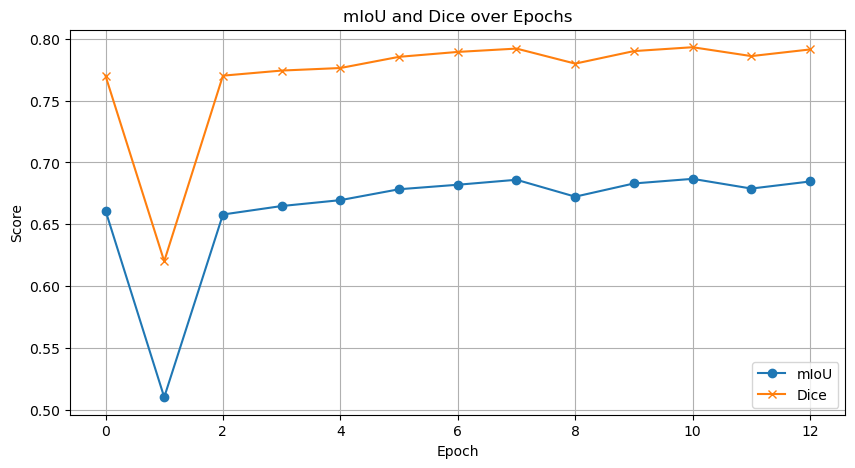

In [8]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=60,
    save_path="unet_resnet34_segmentation.pth",
    checkpoint_path="checkpoint_resnet34.pth"
)

## Performance after 5 epochs

In [ ]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

model.load_state_dict(torch.load("unet_resnet34_segmentation.pth"))


📊 Performance Metrics:
Pixel Accuracy: 0.9905
Per-class Accuracy:
  Background: 0.9984
  Crack: 0.2700
  Pothole: 0.7216
IoU per class:
  Background: 0.9905
  Crack: 0.2541
  Pothole: 0.5483
Mean IoU: 0.5977


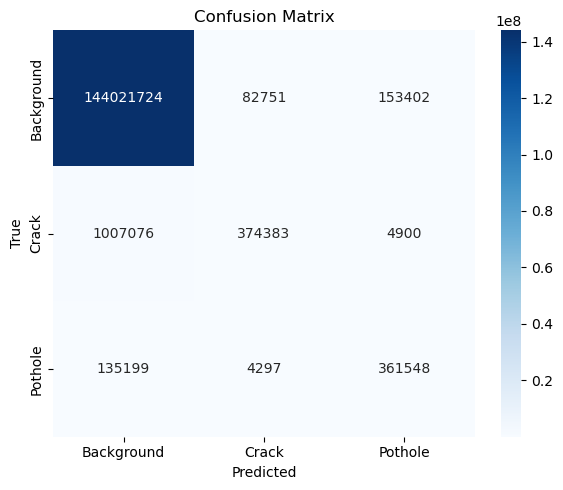

In [11]:
compute_metrics(model, val_loader)  # Test on validation set


📊 Performance Metrics:
Pixel Accuracy: 0.9907
Per-class Accuracy:
  Background: 0.9983
  Crack: 0.2758
  Pothole: 0.7479
IoU per class:
  Background: 0.9908
  Crack: 0.2556
  Pothole: 0.6016
Mean IoU: 0.6160


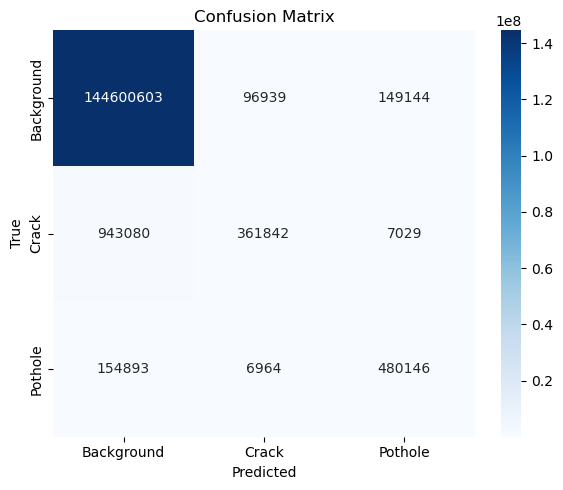

In [12]:
compute_metrics(model, test_loader)  # Test on test set

## Performance after 10 epochs

In [14]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [15]:
model.load_state_dict(torch.load("unet_resnet34_segmentation.pth"))

C:\Users\SHREY\AppData\Local\Temp\ipykernel_19444\3129999517.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_resnet34_segmentation

<All keys matched successfully>

C:\Users\SHREY\AppData\Local\Temp\ipykernel_23728\345587796.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9872
Per-class Accuracy:
  Background: 0.9895
  Crack: 0.8239
  Pothole: 0.8065
IoU per class:
  Background: 0.9873
  Crack: 0.3986
  Pothole: 0.6553
Mean IoU: 0.6804


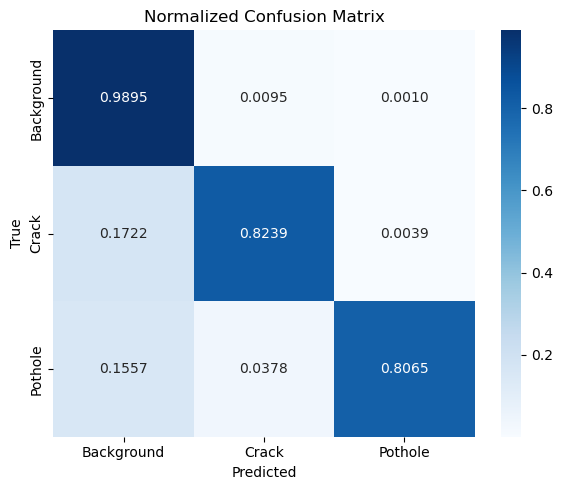


📋 Classification Report:
Class         Precision     Recall   F1-score        IoU    Support
------------------------------------------------------------
Background       0.9977     0.9895     0.9936     0.9873  144846686
Crack            0.4358     0.8239     0.5700     0.3986    1311951
Pothole          0.7775     0.8065     0.7917     0.6553     642003
------------------------------------------------------------
Average          0.7370     0.8733     0.7851     0.6804  146800640


In [9]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_30.pth"))
compute_metrics(model, test_loader)  # Test on test set

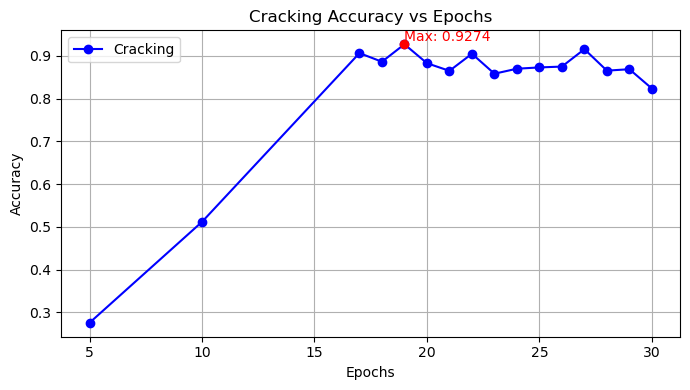

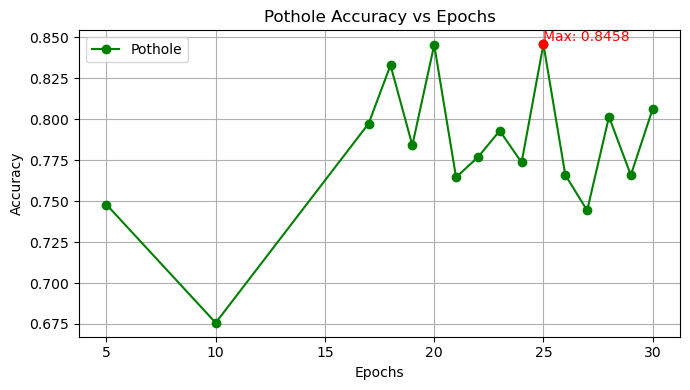

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
data = {
    'Epochs': [5, 10, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'Cracking': [0.2758, 0.5119, 0.9067, 0.8865, 0.9274, 0.8831, 0.8652, 0.9052, 0.8585, 0.8702, 0.8732, 0.8752, 0.9159, 0.8657, 0.869, 0.8239],
    'Pothole': [0.7479, 0.6757, 0.7974, 0.833, 0.7841, 0.8454, 0.7646, 0.7768, 0.793, 0.7736, 0.8458, 0.766, 0.7443, 0.8015, 0.7659, 0.8063]
}
df = pd.DataFrame(data)

# Average accuracy for each epoch
grouped = df.groupby('Epochs').mean().reset_index()

# Function to plot a line chart with highlighted max point
def plot_metric(metric_name, color):
    x = grouped['Epochs']
    y = grouped[metric_name]

    plt.figure(figsize=(7, 4))
    plt.plot(x, y, marker='o', linestyle='-', color=color, label=metric_name)
    
    # Highlight max point
    max_idx = y.idxmax()
    plt.plot(x[max_idx], y[max_idx], 'ro')
    plt.text(x[max_idx], y[max_idx], f'Max: {y[max_idx]:.4f}', 
             ha='left', va='bottom', fontsize=10, color='red')
    
    plt.title(f'{metric_name} Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot both metrics
plot_metric('Cracking', 'blue')
plot_metric('Pothole', 'green')


📊 Performance Metrics:
Pixel Accuracy: 0.9917
Per-class Accuracy:
  Background: 0.9975
  Crack: 0.5080
  Pothole: 0.6736
IoU per class:
  Background: 0.9918
  Crack: 0.4213
  Pothole: 0.5743
Mean IoU: 0.6624


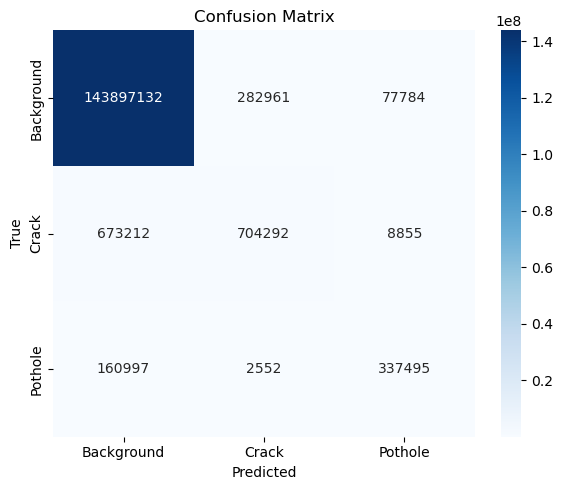

In [16]:
compute_metrics(model, val_loader)  # Test on validation set


📊 Performance Metrics:
Pixel Accuracy: 0.9916
Per-class Accuracy:
  Background: 0.9973
  Crack: 0.5119
  Pothole: 0.6757
IoU per class:
  Background: 0.9917
  Crack: 0.4131
  Pothole: 0.5902
Mean IoU: 0.6650


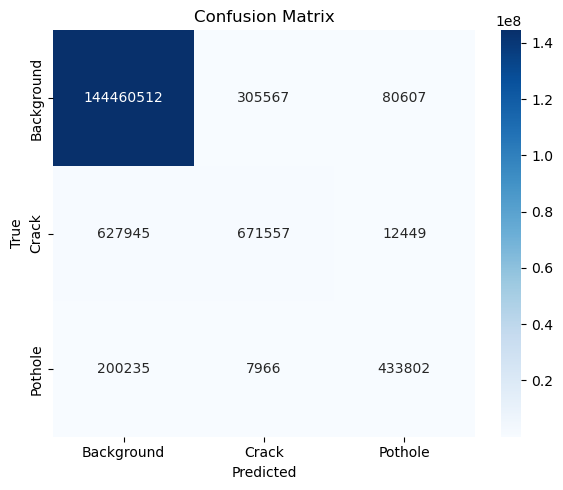

In [17]:
compute_metrics(model, test_loader)  # Test on test set

## Performance after 20 epochs

In [ ]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [12]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_17.pth"))

C:\Users\SHREY\AppData\Local\Temp\ipykernel_20012\1352720681.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn

<All keys matched successfully>


📊 Performance Metrics:
Pixel Accuracy: 0.9721
Per-class Accuracy:
  Background: 0.9735
  Crack: 0.9067
  Pothole: 0.7974
IoU per class:
  Background: 0.9722
  Crack: 0.2588
  Pothole: 0.4064
Mean IoU: 0.5458


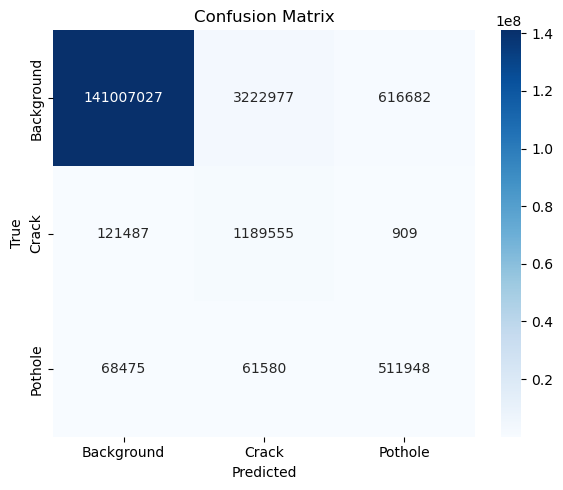

In [13]:
compute_metrics(model, test_loader)  # Test on test set

In [14]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_18.pth"))

C:\Users\SHREY\AppData\Local\Temp\ipykernel_20012\2425572276.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn

<All keys matched successfully>


📊 Performance Metrics:
Pixel Accuracy: 0.9809
Per-class Accuracy:
  Background: 0.9824
  Crack: 0.8865
  Pothole: 0.8330
IoU per class:
  Background: 0.9809
  Crack: 0.3245
  Pothole: 0.5608
Mean IoU: 0.6221


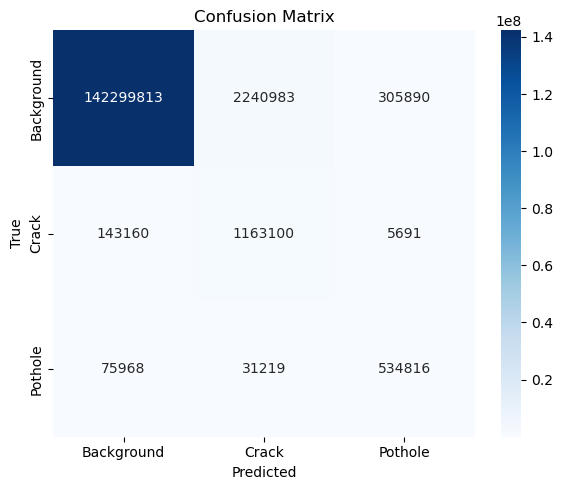

In [15]:
compute_metrics(model, test_loader)  # Test on test set

In [16]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_19.pth"))

C:\Users\SHREY\AppData\Local\Temp\ipykernel_20012\1267243186.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn

<All keys matched successfully>


📊 Performance Metrics:
Pixel Accuracy: 0.9750
Per-class Accuracy:
  Background: 0.9763
  Crack: 0.9274
  Pothole: 0.7841
IoU per class:
  Background: 0.9751
  Crack: 0.2629
  Pothole: 0.6223
Mean IoU: 0.6201


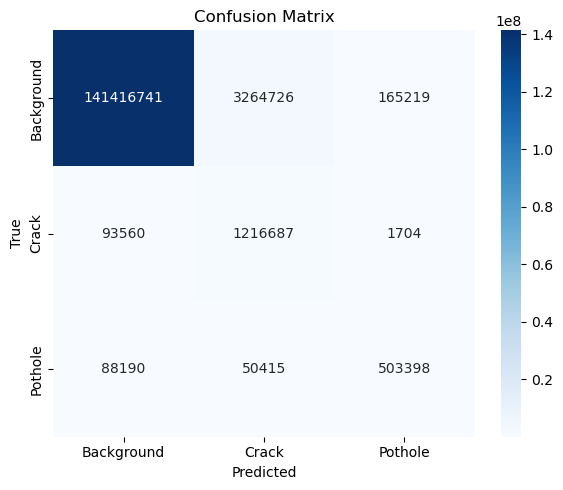

In [17]:
compute_metrics(model, test_loader)  # Test on test set

In [18]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_20.pth"))

C:\Users\SHREY\AppData\Local\Temp\ipykernel_20012\554350130.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc

<All keys matched successfully>


📊 Performance Metrics:
Pixel Accuracy: 0.9804
Per-class Accuracy:
  Background: 0.9819
  Crack: 0.8831
  Pothole: 0.8454
IoU per class:
  Background: 0.9804
  Crack: 0.3206
  Pothole: 0.5406
Mean IoU: 0.6139


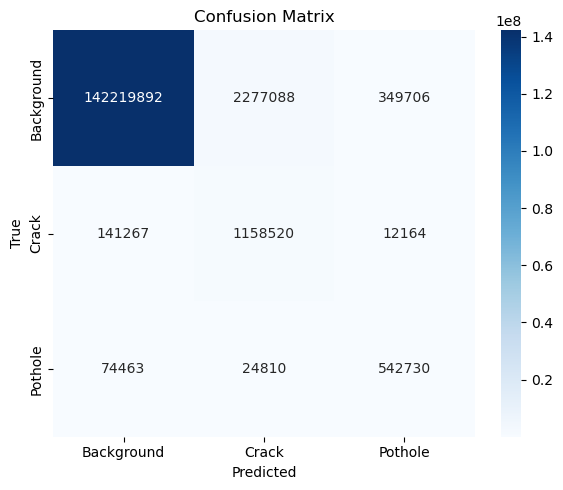

In [19]:
compute_metrics(model, test_loader)  # Test on test set

## Performance after 30 epochs

In [10]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [10]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_30.pth"))

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\3464900958.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn

<All keys matched successfully>


📊 Performance Metrics:
Pixel Accuracy: 0.9872
Per-class Accuracy:
  Background: 0.9895
  Crack: 0.8239
  Pothole: 0.8063
IoU per class:
  Background: 0.9873
  Crack: 0.3988
  Pothole: 0.6551
Mean IoU: 0.6804


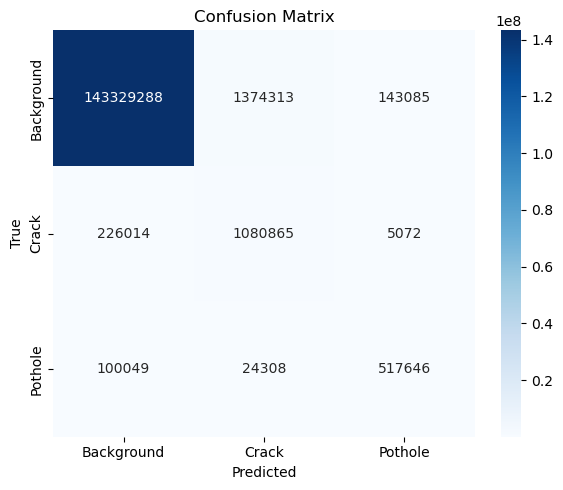

In [11]:
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\887739402.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9839
Per-class Accuracy:
  Background: 0.9859
  Crack: 0.8690
  Pothole: 0.7659
IoU per class:
  Background: 0.9841
  Crack: 0.3520
  Pothole: 0.6153
Mean IoU: 0.6505


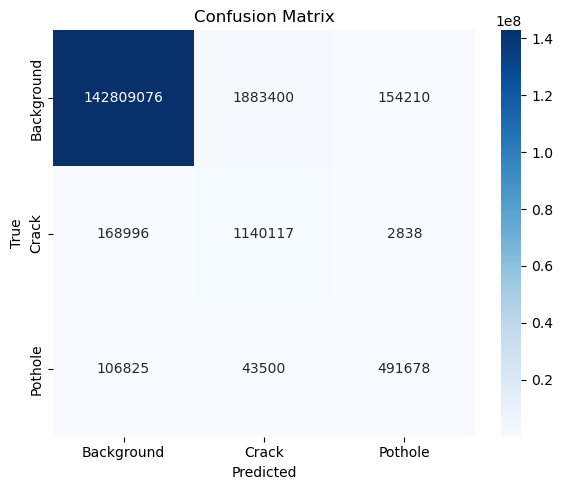

In [12]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_29.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\1558907137.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn


📊 Performance Metrics:
Pixel Accuracy: 0.9840
Per-class Accuracy:
  Background: 0.9859
  Crack: 0.8657
  Pothole: 0.8015
IoU per class:
  Background: 0.9841
  Crack: 0.3533
  Pothole: 0.6308
Mean IoU: 0.6561


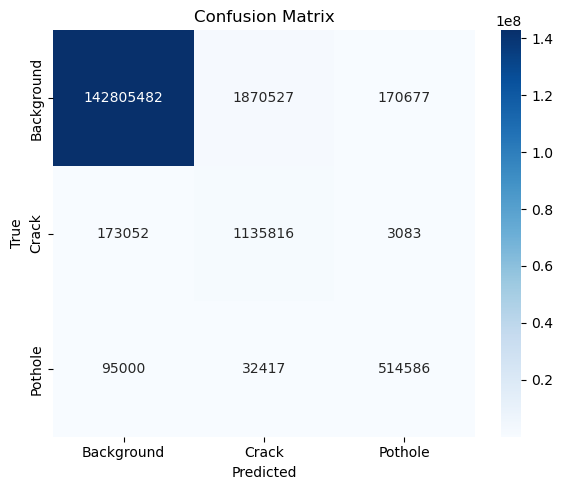

In [13]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_28.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\913415417.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9763
Per-class Accuracy:
  Background: 0.9779
  Crack: 0.9159
  Pothole: 0.7443
IoU per class:
  Background: 0.9764
  Crack: 0.2778
  Pothole: 0.5439
Mean IoU: 0.5994


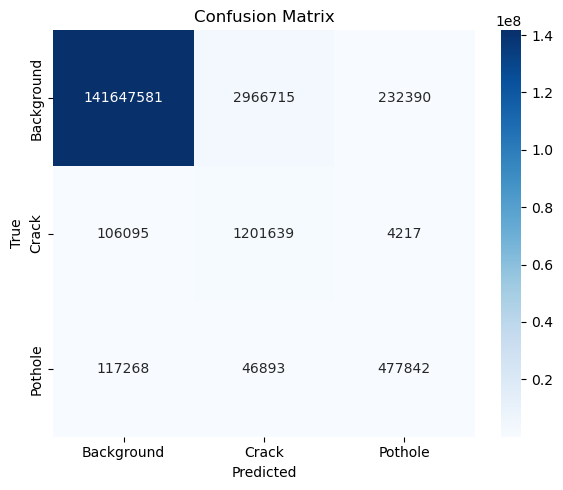

In [14]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_27.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\3393741747.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn


📊 Performance Metrics:
Pixel Accuracy: 0.9834
Per-class Accuracy:
  Background: 0.9854
  Crack: 0.8752
  Pothole: 0.7660
IoU per class:
  Background: 0.9835
  Crack: 0.3461
  Pothole: 0.6219
Mean IoU: 0.6505


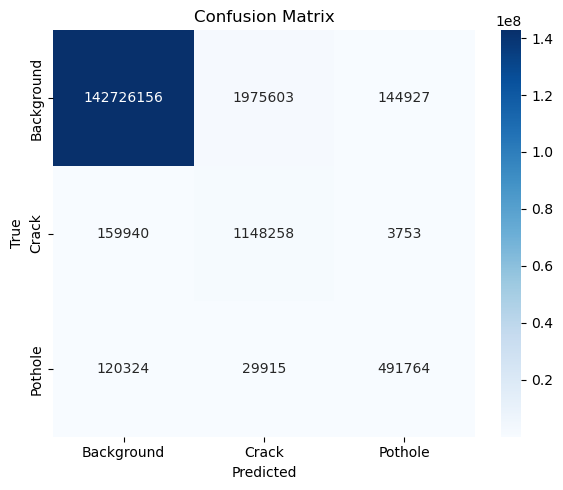

In [15]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_26.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\2796350885.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn


📊 Performance Metrics:
Pixel Accuracy: 0.9838
Per-class Accuracy:
  Background: 0.9854
  Crack: 0.8732
  Pothole: 0.8458
IoU per class:
  Background: 0.9839
  Crack: 0.3536
  Pothole: 0.6362
Mean IoU: 0.6579


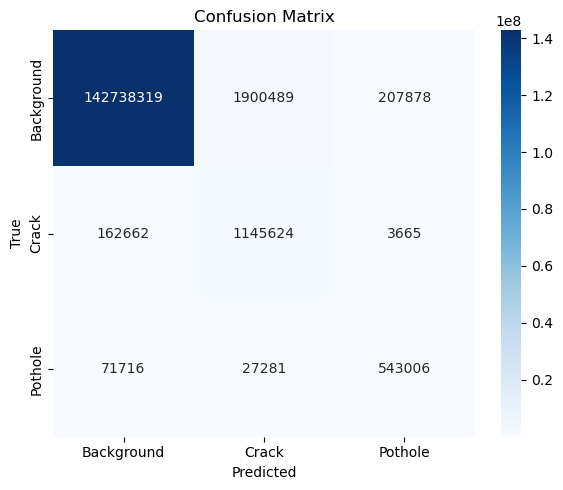

In [16]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_25.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\3660775928.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn


📊 Performance Metrics:
Pixel Accuracy: 0.9830
Per-class Accuracy:
  Background: 0.9849
  Crack: 0.8702
  Pothole: 0.7736
IoU per class:
  Background: 0.9830
  Crack: 0.3380
  Pothole: 0.6236
Mean IoU: 0.6482


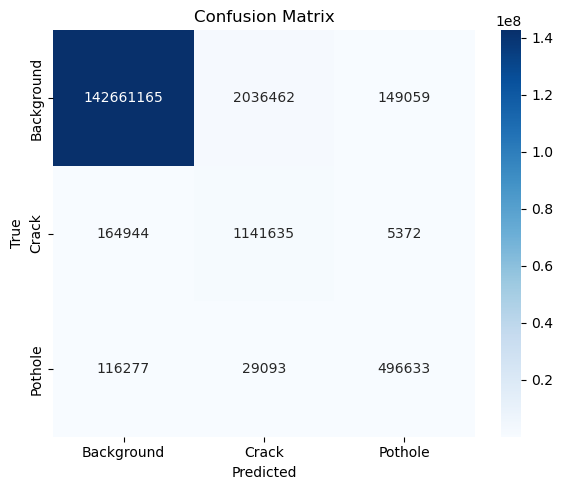

In [17]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_24.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\998961011.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9844
Per-class Accuracy:
  Background: 0.9864
  Crack: 0.8585
  Pothole: 0.7930
IoU per class:
  Background: 0.9844
  Crack: 0.3623
  Pothole: 0.5962
Mean IoU: 0.6476


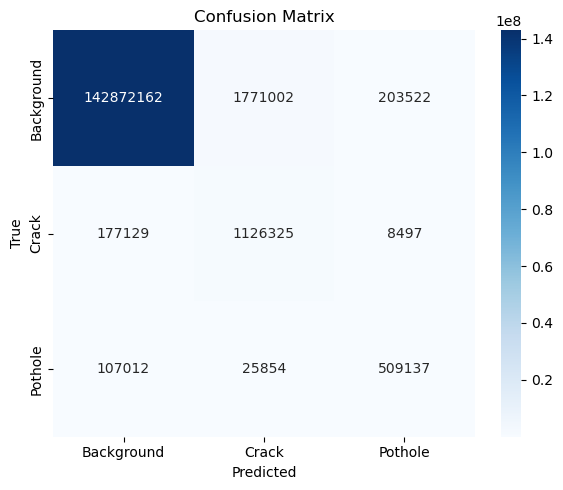

In [18]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_23.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\452205442.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9788
Per-class Accuracy:
  Background: 0.9804
  Crack: 0.9052
  Pothole: 0.7768
IoU per class:
  Background: 0.9788
  Crack: 0.2974
  Pothole: 0.5947
Mean IoU: 0.6236


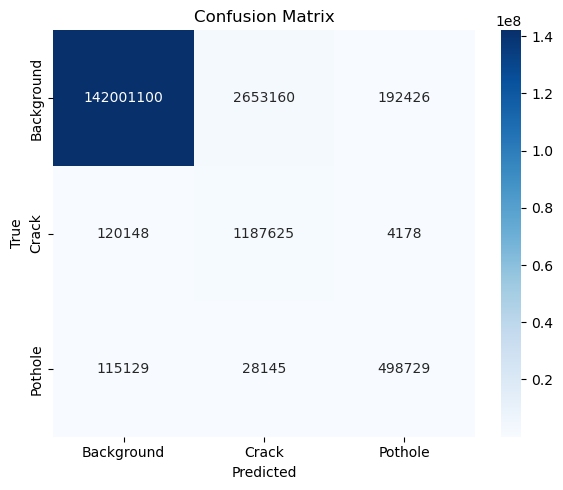

In [19]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_22.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_12656\4243469887.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn


📊 Performance Metrics:
Pixel Accuracy: 0.9835
Per-class Accuracy:
  Background: 0.9855
  Crack: 0.8652
  Pothole: 0.7646
IoU per class:
  Background: 0.9836
  Crack: 0.3443
  Pothole: 0.6191
Mean IoU: 0.6490


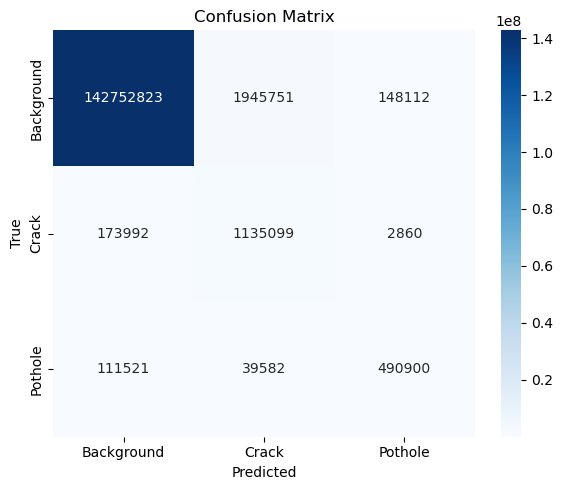

In [20]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_21.pth"))
compute_metrics(model, test_loader)  # Test on test set

## Performance Analysis

In [8]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

       # Normalized confusion matrix
    cm_normalized = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

    from sklearn.metrics import precision_score, recall_score, f1_score

    # Calculate additional metrics
    precision = precision_score(all_labels, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, labels=range(NUM_CLASSES), average=None, zero_division=0)
    support = np.array([(all_labels == i).sum() for i in range(NUM_CLASSES)])

    print("\n📋 Classification Report:")
    print(f"{'Class':<12} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'IoU':>10} {'Support':>10}")
    print("-" * 60)
    for i in range(NUM_CLASSES):
        print(f"{CLASS_NAMES[i]:<12} {precision[i]:10.4f} {recall[i]:10.4f} {f1[i]:10.4f} {ious[i]:10.4f} {support[i]:10}")

    # Macro averages
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1 = f1.mean()
    mean_iou = np.mean(ious)

    print("-" * 60)
    print(f"{'Average':<12} {macro_precision:10.4f} {macro_recall:10.4f} {macro_f1:10.4f} {mean_iou:10.4f} {support.sum():10}")


In [11]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Standardize Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    print("\n📋 Standardized Confusion Matrix (rows sum to 1):")
    for i, row in enumerate(cm_normalized):
        row_str = '  '.join(f"{val:.4f}" for val in row)
        print(f"{CLASS_NAMES[i]:<10}: {row_str}")

    # Plot standardized confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Standardized Confusion Matrix")
    plt.tight_layout()
    plt.show()

C:\Users\SHREY\AppData\Local\Temp\ipykernel_21628\223763819.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9889
Per-class Accuracy:
  Background: 0.9915
  Crack: 0.8063
  Pothole: 0.7693
IoU per class:
  Background: 0.9890
  Crack: 0.4325
  Pothole: 0.6486
Mean IoU: 0.6900


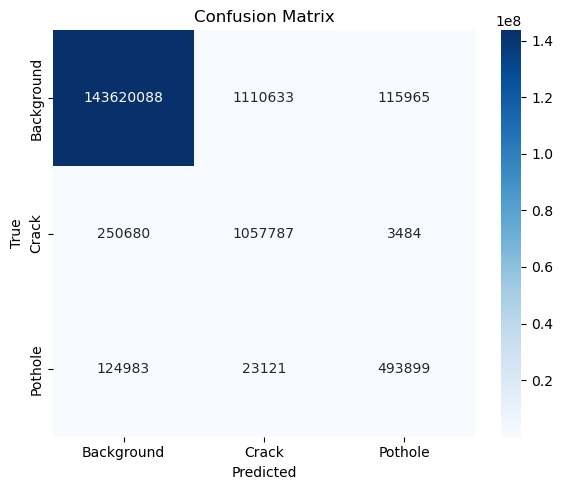

In [10]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\unet_resnet34_segmentation.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_21628\345587796.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9872
Per-class Accuracy:
  Background: 0.9895
  Crack: 0.8239
  Pothole: 0.8063
IoU per class:
  Background: 0.9873
  Crack: 0.3988
  Pothole: 0.6551
Mean IoU: 0.6804


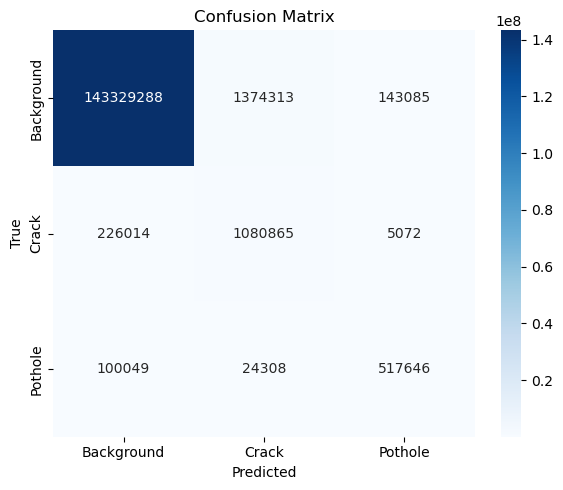

In [11]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\models_train2\model_epoch_30.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_15728\223763819.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnc


📊 Performance Metrics:
Pixel Accuracy: 0.9889
Per-class Accuracy:
  Background: 0.9915
  Crack: 0.8063
  Pothole: 0.7696
IoU per class:
  Background: 0.9890
  Crack: 0.4324
  Pothole: 0.6488
Mean IoU: 0.6901

📋 Standardized Confusion Matrix (rows sum to 1):
Background: 0.9915  0.0077  0.0008
Crack     : 0.1910  0.8063  0.0027
Pothole   : 0.1944  0.0360  0.7696


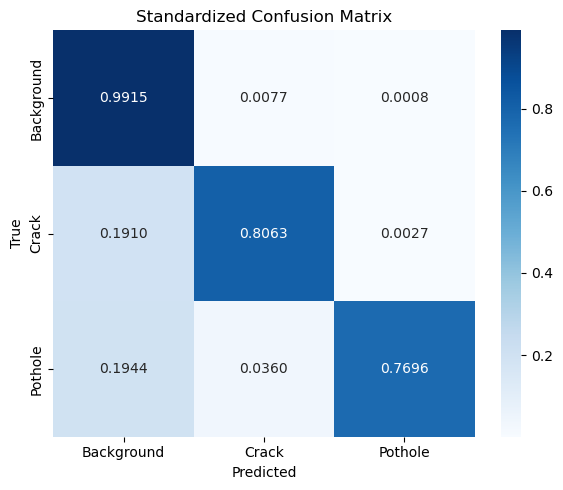

In [11]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\unet_resnet34_segmentation.pth"))
compute_metrics(model, test_loader)  # Test on test set

C:\Users\SHREY\AppData\Local\Temp\ipykernel_15188\3240416484.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gn


📊 Performance Metrics:
Pixel Accuracy: 0.9890
Per-class Accuracy:
  Background: 0.9916
  Crack: 0.7985
  Pothole: 0.7930
IoU per class:
  Background: 0.9891
  Crack: 0.4283
  Pothole: 0.6781
Mean IoU: 0.6985

📋 Standardized Confusion Matrix (rows sum to 1):
Background: 0.9916  0.0076  0.0007
Crack     : 0.1992  0.7985  0.0023
Pothole   : 0.1644  0.0426  0.7930


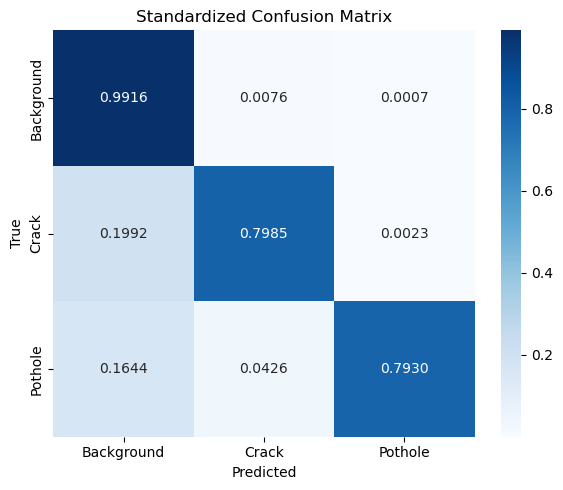

In [12]:
model.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\last_model.pth"))
compute_metrics(model, test_loader)  # Test on test set